In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import torch
import pandas as pd
import ott
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp

from pathlib import Path
import os
from regression_model import *
from utils.utils import mean_cross_entropy

In [4]:
p_data = Path("../data/raw_pitch_data/")
ex_data = pd.concat([pd.read_csv(p_data / csv_path) for csv_path in os.listdir(p_data)[5:30]])
freq_pitchers = ex_data['pitcher'].value_counts().iloc[:10].index

In [5]:
pitcher = freq_pitchers[6]
pitcher_data = ex_data[ex_data["pitcher"] == pitcher]
pitcher_ff_data = pitcher_data[pitcher_data["pitch_type"] == "FF"]

# pitcher_data.loc[:, "is_strike"] = 
# pitcher_data["description"].apply(lambda s: s in ["swinging_strike", "called_strike"])
description_value_counts = pitcher_data["description"].value_counts()
infrequent_descriptions = description_value_counts[description_value_counts <= 100].index
modified_descriptions = pitcher_data["description"].apply(lambda r: "other" if r in infrequent_descriptions else r)
outcome_df = pd.concat([pitcher_data["game_date"], pd.get_dummies(modified_descriptions)], axis =1)
valid_samples = outcome_df.groupby("game_date").count()['other'] > 30
avg_outcomes = outcome_df.groupby("game_date").mean()[valid_samples]
# pitcher_data.loc[:, "is_ball"] = pitcher_data["description"] == "ball"
# pitcher_data.groupby("game_date").sum(["is_strike", "is_ball"])

In [6]:
one_hot_descriptions = pd.get_dummies(modified_descriptions)
descriptions_array = np.array(one_hot_descriptions).astype(int)
# filter = np.ones(100) / 100
n = 100
filter = sp.ndimage.gaussian_filter1d(np.concatenate([np.zeros(n), [1.], np.zeros(n)]), n / 3)
filtered_descriptions = np.apply_along_axis(lambda v: np.convolve(v, filter, mode="same"), 0, descriptions_array)
filtered_descriptions /= np.sum(filtered_descriptions, axis = -1)[:, None]

In [10]:
outcome_df.groupby("game_date").mean()

,ball,called_strike,foul,hit_into_play,other,swinging_strike
game_date,,,,,,
2019-06-09,0.317308,0.250000,0.182692,0.163462,0.019231,0.067308
2019-06-15,0.365591,0.204301,0.172043,0.161290,0.021505,0.075269
2019-06-21,0.186916,0.214953,0.196262,0.186916,0.065421,0.149533
2019-06-27,0.323529,0.196078,0.166667,0.127451,0.098039,0.088235
2019-07-02,0.358974,0.213675,0.128205,0.162393,0.034188,0.102564
2019-07-07,0.303030,0.171717,0.202020,0.181818,0.020202,0.121212
2019-07-13,0.309091,0.209091,0.209091,0.118182,0.054545,0.100000
2019-07-18,0.404040,0.202020,0.191919,0.151515,0.000000,0.050505
2019-07-23,0.304762,0.200000,0.171429,0.161905,0.076190,0.085714


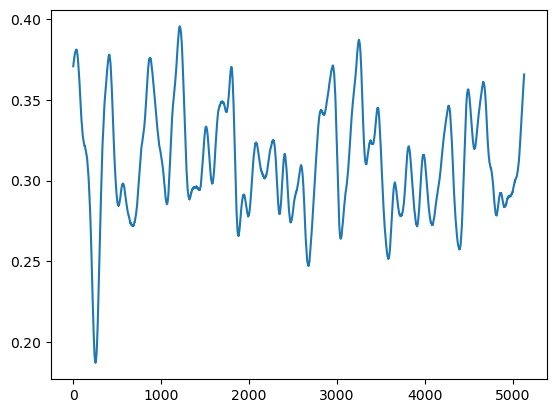

In [62]:
plt.plot(filtered_descriptions[:, 0])

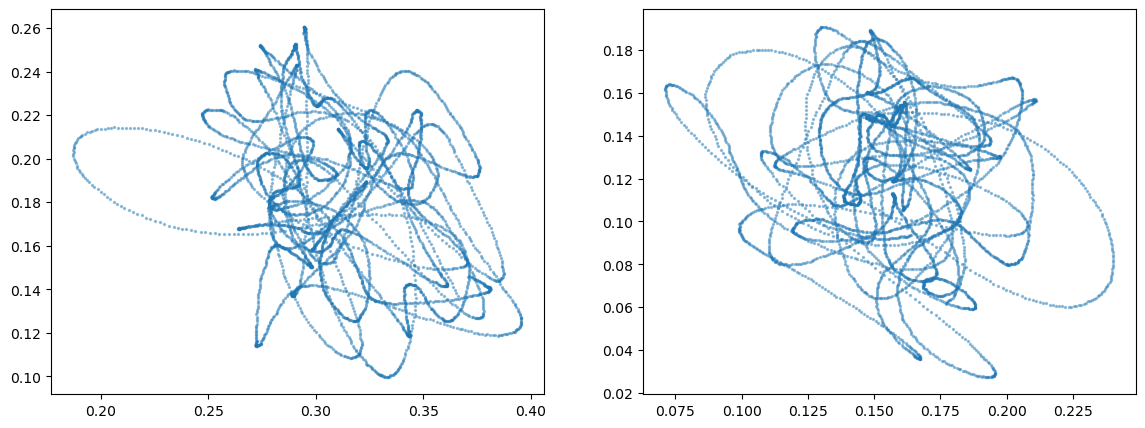

In [63]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
axs[0].scatter(filtered_descriptions[:, 0], filtered_descriptions[:, 2], s = 2, alpha=0.4)
axs[1].scatter(filtered_descriptions[:, 3], filtered_descriptions[:, 5], s = 2, alpha=0.4)

In [66]:
# filtered_descriptions

def score_filter(n: int, arr: np.ndarray):
  arr = arr if len(arr) % 2 == 0 else arr[:-1]
  train_arr = arr[0::2]
  test_arr = arr[1::2]
  filter = sp.ndimage.gaussian_filter1d(np.concatenate([np.zeros(n), [1.], np.zeros(n)]), n / 3)
  filtered_arr = np.apply_along_axis(lambda v: np.convolve(v, filter, mode="same"), 0, train_arr)
  filtered_arr /= np.sum(filtered_arr, axis = -1)[:, None]
  return mean_cross_entropy(test_arr, filtered_arr)

  
scores = []
for n in [10, 20, 40, 80, 160, 320, 640, 1280]:
  scores.append(score_filter(n, descriptions_array))

In [67]:
scores

[2.5738995535849307,
 1.989550951146572,
 1.7348182372427507,
 1.691008313997633,
 1.6771563280587924,
 1.6720479386064926,
 1.669594830692691,
 1.668252153624605]

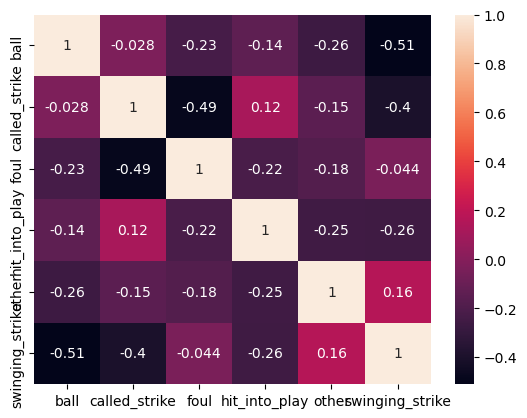

In [12]:
fig, ax = plt.subplots()
sns.heatmap(np.corrcoef(filtered_descriptions.T), annot=True, ax =ax)
ax.set(xticklabels=one_hot_descriptions.columns, yticklabels=one_hot_descriptions)
plt.show()

In [25]:
average_ff_speed = pitcher_ff_data.groupby("game_date").mean('release_speed')
# pitcher_data.groupby("game_date").sum(["strikes", "b"])
# strikes_to_balls = 

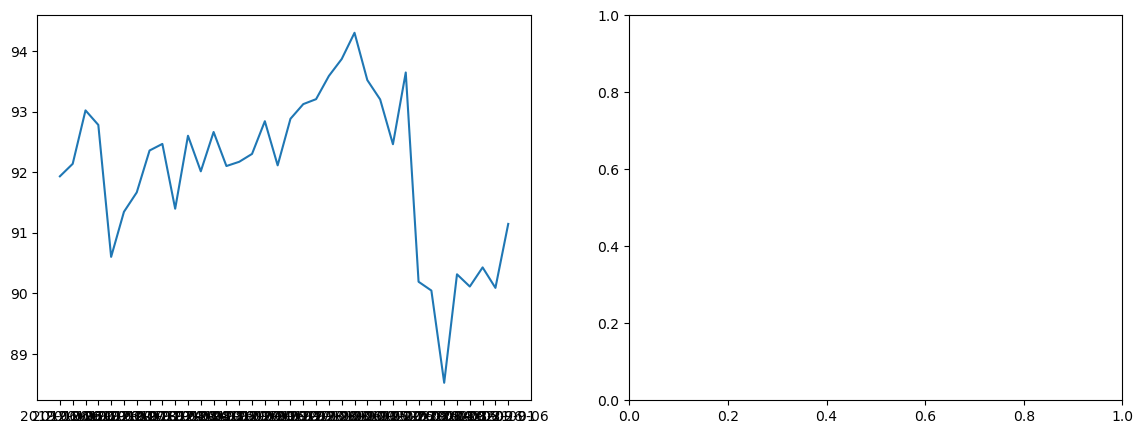

In [26]:
fig, ax = plt.subplots(1, 2, figsize = (14, 5))
x = average_ff_speed.index
ff_release_speed = average_ff_speed['release_speed']
ax[0].plot(x, ff_release_speed)
# x = avg_outcomes.index
# y_ball = avg_outcomes['ball']
# y_strike = avg_outcomes["called_strike"] + avg_outcomes["swinging_strike"]
# ax[1].plot(x, y_strike)


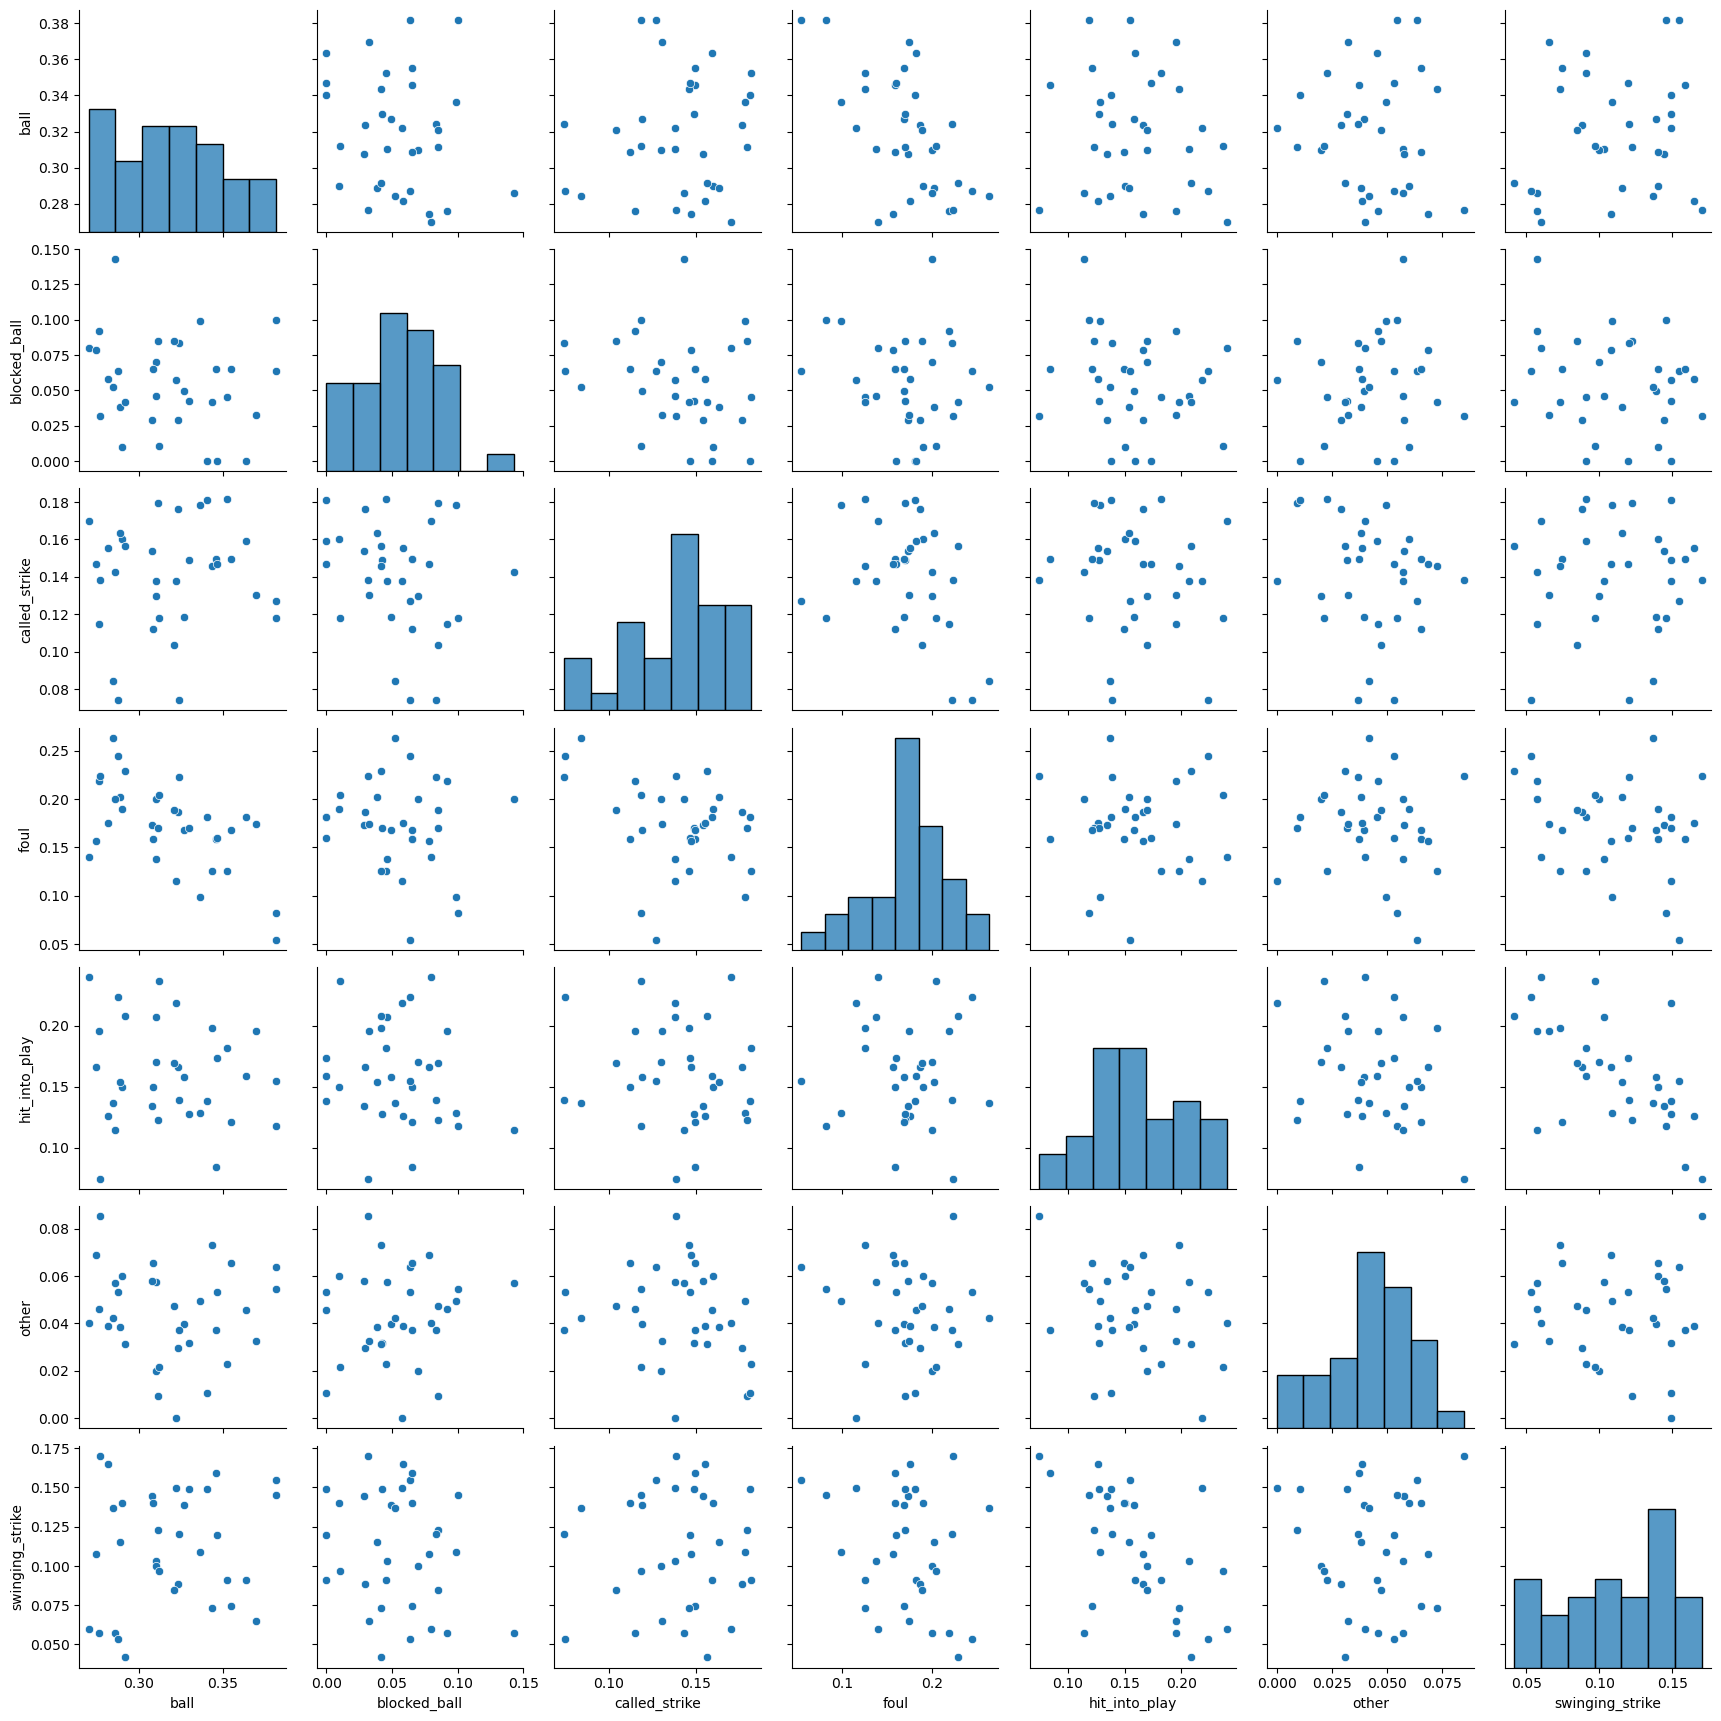

In [27]:
sns.pairplot(avg_outcomes)